Author-VIRAJ RANADE
CV-24678 Project
This Notebook is made as a toolbox to try and run the results of our Analysis. These Embeddings are used to show the differences between the 2 X-ray sets. The PCA embeddings are contrasted and shown to have changes depending on what set they are from.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [311]:
import numpy as np
import torch
import cv2
import PIL
import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [3]:
normal='/content/drive/MyDrive/CV_project/normal/*.*'
osteoporosis='/content/drive/MyDrive/CV_project/osteoporosis/*.*'

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [5]:
def create_dataset(path1,path2):
  set_1=glob.glob(path1)
  set_2=glob.glob(path2)

  s1=[]
  s2=[]
  lab1=np.zeros((186))
  lab2=np.ones((186))
  count=0

  for i in set_1:
    count +=1
    #print(count)
    temp1=cv2.imread(i)
    gray1=cv2.cvtColor(temp1,cv2.COLOR_BGR2GRAY)
    gray_scaled1=cv2.resize(gray1,(156,235)).flatten()
    s1.append(gray_scaled1)
    #lab.append(0)

  for i in set_2:
    count +=1
    #print(count)
    temp2=cv2.imread(i)
    gray2=cv2.cvtColor(temp2,cv2.COLOR_BGR2GRAY)
    gray_scaled2=cv2.resize(gray2,(156,235)).flatten()
    s2.append(gray_scaled2)
    #lab.append(1)

  s1=np.asarray(s1)
  s2=np.asarray(s2)
  data_2=np.concatenate((s1,s2),axis=0)
  lab=np.concatenate((lab1,lab2),axis=0)
  print(type(data_2))
  return data_2,lab


In [ ]:
data_20,labels_20=create_dataset(normal,osteoporosis)
print(data_20.shape)
print(labels_20.shape)

In [ ]:
len(data_20)
len(labels_20)


In [243]:
labels_0=np.hstack((labels_20.reshape(372,1),labels_20.reshape(372,1)))
print(np.shape(labels_0))

(372, 2)


In [245]:
import sklearn
import sklearn.decomposition as dec
from sklearn import model_selection
train_2,test_2,train_labels_2,test_labels_2,labels_0_t,labels_0_test=sklearn.model_selection.train_test_split(data_20,labels_20,labels_0,test_size=0.15)

In [246]:
len(train_2)

316

In [247]:
class MyDataSet(Dataset):
  def __init__(self,x,y):
    self.x=x
    self.y=y
    #self.length=np.shape(self.data)[0]
    self.length=len(self.x)
    #print(self.length)

  def __len__(self):
    return self.length

  def __getitem__(self,index):
    xx=torch.FloatTensor(self.x[index])
    yy=torch.FloatTensor(self.y[index])
    return xx,yy

In [248]:
train_set=MyDataSet(train_2,train_labels_2.reshape(316,1))
train_args=dict(shuffle=True,batch_size=32,num_workers=1,collate_fn=None)
train_loader=DataLoader(train_set,**train_args)

val_set=MyDataSet(test_2,test_labels_2.reshape(56,1))
val_args=dict(shuffle=False,batch_size=32,num_workers=1,collate_fn=None)
val_loader=DataLoader(val_set,**val_args)

In [249]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [250]:
class MLP(nn.Module):
  def __init__(self,input_size,hiddens,output_size):
    super(MLP,self).__init__()
    Linear_layers=[nn.Linear(input_size,hiddens[0],bias=True),nn.BatchNorm1d(hiddens[0]),nn.ReLU(inplace=True),nn.Dropout(0.5)]
    for i in range(len(hiddens)-1):
      Linear_layers.append(nn.Linear(hiddens[i],hiddens[i+1],bias=True))
      Linear_layers.append(nn.BatchNorm1d(hiddens[i+1]))
      Linear_layers.append(nn.ReLU(inplace=True))
      Linear_layers.append(nn.Dropout(0.5))
    Linear_layers.append(nn.Linear(hiddens[i+1],output_size))

    self.layers=nn.Sequential(*Linear_layers)

  def forward(self,x):
    return self.layers(x)

In [251]:
input=48
hiddens=[512,256,128,64,32]
output=2
steps=[x for x in np.arange(10)*5]
print(steps)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]


In [252]:

model=MLP(input,hiddens,output)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler=optim.lr_scheduler.MultiStepLR(optimizer,steps)

device=torch.device('cuda' if torch.cuda else 'cpu')
model=model.to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=48, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): BatchNorm1d(32, eps=1

In [253]:
class Block(nn.Module):
  def __init__(self,in_channels,hidden_channels,out_channels,kernel_size=3,stride=1):
    self.stride=stride
    super().__init__()

    self.in_channel=in_channels
    self.hidden_channels=hidden_channels
    self.out_channels=out_channels
    self.kernel_size=kernel_size

    self.b=nn.Sequential(nn.Conv2d(self.in_channel,self.hidden_channels,self.kernel_size),nn.BatchNorm2d(self.hidden_channels),nn.ReLU(),
                         nn.Conv2d(self.hidden_channels,self.hidden_channels,self.kernel_size),nn.BatchNorm2d(self.hidden_channels),nn.ReLU(),
                         nn.Conv2d(self.hidden_channels,self.out_channels,self.kernel_size),nn.BatchNorm2d(self.out_channels))
    
    if self.stride==1:
      self.s=nn.Identity()
    else:
      self.s=nn.Sequential(nn.Conv2d(self.in_channel,self.out_channels,kernel_size=3,stride=self.stride,padding=1),nn.BatchNorm2d(self.out_channels))
    
  def forward(self,x,flag):

    embedding=self.b(x)
    shortcut=self.s(x)
    if flag:
      self.out=nn.ELU(embedding+shortcut)
    else:
      self.out=nn.ReLU(embedding+shortcut)
    
    return self.out

In [254]:
class CNN(nn.Module):
  def __init__(self,in_features,num_classes,feat_dim=1):
    super().__init__()
    self.convolutional_layers=nn.Sequential(
        nn.Conv2d(in_features,64,kernel_size=3,stride=2,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        Block(64,128,64,kernel_size=1,stride=1),
        Block(64,128,64,kernel_size=1,stride=1),
        Block(64,128,128,kernel_size=3,stride=2),
        Block(128,256,128,kernel_size=1,stride=1),
        Block(128,256,128,kernel_size=1,stride=1),
        Block(128,256,256,kernel_size=3,stride=2),
        Block(256,512,512,kernel_size=1,stride=1),
        Block(512,1024,1024,kernel_size=3,stride=2),

        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten()
    )

    self.linear_layers=nn.Sequential(nn.Linear(1024,512),nn.BatchNorm1d(512),nn.ReLU(inplace=True),nn.Dropout(0.5),
                nn.Linear(512,256),nn.BatchNorm1d(256),nn.ReLU(inplace=True),nn.Dropout(0.5),
                nn.Linear(256,128),nn.BatchNorm1d(128),nn.ReLU(inplace=True),nn.Dropout(0.5),
                nn.Linear(128,32),nn.BatchNorm1d(32),nn.ReLU(inplace=True),nn.Dropout(0.5),
                nn.Linear(32,2)
    )

  def forward(self,x,return_embedding=False):
    embedding=self.convolutional_layers(x)
    output=self.linear_layers(embeddings)
    if return_embedding:
      return embedding,output
    else:
      return output

In [255]:
network=CNN(48,2,1)
network.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler=optim.lr_scheduler.MultiStepLR(optimizer,steps)

print(network)

CNN(
  (convolutional_layers): Sequential(
    (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Block(
      (b): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (s): Identity()
    )
    (4): Block(
      (b): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [256]:
PCA=dec.PCA()

In [257]:
p1=PCA.fit(train_2)

In [258]:
evr=p1.explained_variance_ratio_
sum=0
for i in range(316):
  if sum<0.90:
    sum +=evr[i]
  else:
    print(i)
    break

47


In [259]:
pc2=dec.PCA(48)
p2=pc2.fit(train_2)
p_train=pc2.fit_transform(train_2)
p_test=pc2.fit_transform(test_2)

In [260]:
print(p_train.shape)
print(p_test.shape)

(316, 48)
(56, 48)


In [261]:
'''
p_train_set=MyDataSet(p_train,train_labels_2.reshape(316,1))
p_train_args=dict(shuffle=True,batch_size=32,num_workers=1,collate_fn=None)
p_train_loader=DataLoader(p_train_set,**p_train_args)

p_val_set=MyDataSet(p_test,test_labels_2.reshape(56,1))
p_val_args=dict(shuffle=False,batch_size=56,num_workers=1,collate_fn=None)
p_val_loader=DataLoader(p_val_set,**p_val_args)
'''

p_train_set=MyDataSet(p_train,labels_0_t.reshape(316,2))
p_train_args=dict(shuffle=True,batch_size=32,num_workers=1,collate_fn=None)
p_train_loader=DataLoader(p_train_set,**p_train_args)

p_val_set=MyDataSet(p_test,labels_0_test.reshape(56,2))
p_val_args=dict(shuffle=False,batch_size=56,num_workers=1,collate_fn=None)
p_val_loader=DataLoader(p_val_set,**p_val_args)

In [262]:
print(p_train_set.__getitem__(1))

(tensor([  553.4657,  4232.0723,   860.2151, -3869.1138, -2491.0764, -2826.4512,
        -2090.8821, -1913.9744,  1621.8002,   634.4963,  -560.2300, -1062.5269,
        -3044.9595,    69.6450,  1077.4431,   207.7576,   715.4187,   -11.6350,
          751.6414,  -198.7414,  -938.2593,  1363.0977,   843.2075,  1267.5291,
          696.2042,  -637.1881, -1069.4681,   863.9239,  1055.5883,   234.3027,
         -131.4651,  -375.4240,  -193.4159,  -860.3875,   -56.1906,   346.0004,
           73.1812,   -25.3776,   910.1343,   108.0854,   179.0682,   -97.9530,
         -378.4605,  -711.6135,   433.7579,  -113.5476,   587.7101,    97.8867]), tensor([1., 1.]))


In [263]:
print(train_labels_2)

[0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0.]


In [ ]:
#train
nepochs=20000

for epoch in range(nepochs):
  start=time.time()
  train_loss=0
  model.train()

  for batch,(datax,labelsy) in enumerate(p_train_loader):
    datax,labelsy=datax.to(device),labelsy.to(device)
    optimizer.zero_grad()
    outputz=model(datax)
    #print(outputz)

    loss=criterion(outputz,labelsy)
    loss.backward()
    train_loss +=loss.item()
    
    optimizer.step()

  train_loss /=(len(p_train_loader))
  print('Epoch',epoch,'Train_loss is',train_loss)

  with torch.no_grad():
    model.eval()

    guess=[]
    val_loss=0
    for index,(x,y) in enumerate(p_val_loader):

      x=x.to(device)
      y=y.to(device)

      pred=model(x)
      loss=criterion(pred,y)

      val_loss +=loss.item()
      #print(pred)
      pred=pred.cpu().detach().numpy()
      
      pred=np.argmax(pred,axis=1)
      guess.append(pred)
    val_loss /= len(p_val_loader)
    print('Validation loss is',val_loss)
    scheduler.step()
    if (epoch+1)%5==0:
      #print(pred)
      pass


In [268]:
for batch,(m,n) in enumerate(p_val_loader):
  m=m.to(device)
  out=model(m)
  out=out.cpu().detach().numpy()
  out=np.argmax(out,axis=1)
print(out.shape)

(56,)


In [271]:
count=0
for i in range(56):
  if out[i]==test_labels_2[i]:
    count=count+1

print(count/56)


0.5535714285714286


In [330]:
normal_set=data_20[:186]
osteoporotic_set=data_20[186:]

normal_mean=normal_set.mean(axis=0)
osteoporotic_mean=osteoporotic_set.mean(axis=0)

print(normal_mean-osteoporotic_mean)

[-0.58064516 -0.2311828   1.22043011 ...  9.17204301 10.83870968
  9.6344086 ]


In [ ]:
for i in range(10):
  print(np.sum(normal_set[i]-osteoporotic_set[i]))

In [326]:
PCA_48=dec.PCA(48)

In [327]:
np1=PCA.fit(normal_set)
op1=PCA.fit(osteoporotic_set)

np48=PCA_48.fit(normal_set)
op48=PCA_48.fit(osteoporotic_set)

In [329]:
tn48=PCA_48.fit_transform(normal_set)
to48=PCA_48.fit_transform(osteoporotic_set)

print(tn48.shape,to48.shape)

(186, 48) (186, 48)


In [313]:
npc=np1.components_
opc=op1.components_

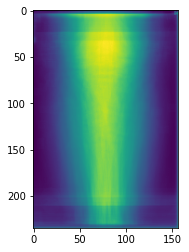

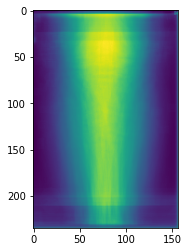

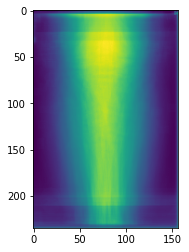

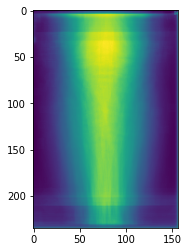

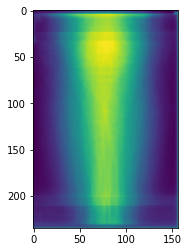

In [350]:
for i in range(5):
  n=npc[i].reshape(235,156)
  n1=n+normal_mean.reshape(235,156)
  plt.imsave('i'+'Mean_added_Principal_components_normal.jpg',n)
  plt.imshow(n1)
  plt.show()


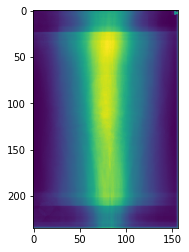

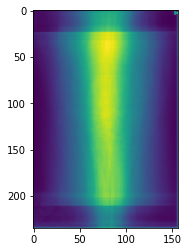

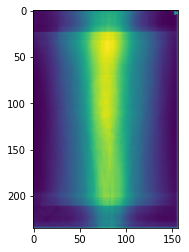

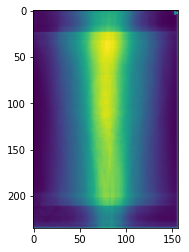

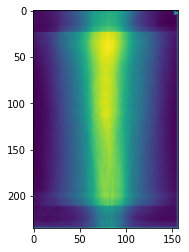

In [351]:
for i in range(5):
  o=opc[i].reshape(235,156)
  o=osteoporotic_mean.reshape(235,156)+o
  plt.imsave('i'+'Mean_added_Principal_components_osteoporosis.jpg',o)
  plt.imshow(o)
  plt.show()

In [ ]:
plt.imshow(normal_mean.reshape(235,156))

In [ ]:
plt.imshow(osteoporotic_mean.reshape(235,156))

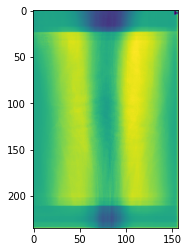

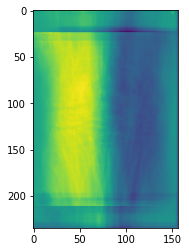

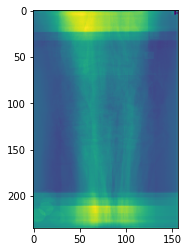

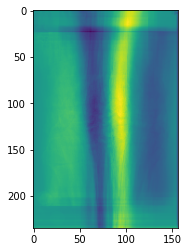

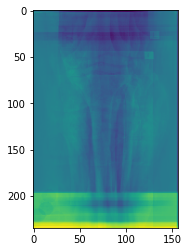

In [352]:
for i in range(5):
  n=np48.components_[i].reshape(235,156)
  plt.imsave('i'+'Principal_components_normal.jpg',n)
  plt.imshow(n)
  plt.show()

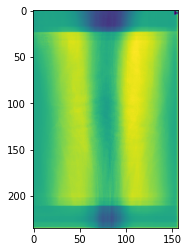

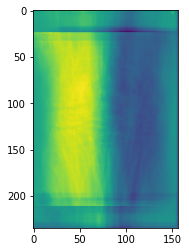

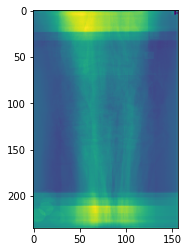

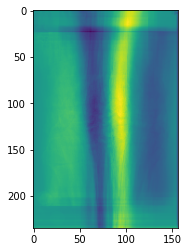

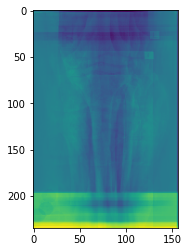

In [356]:
for i in range(5):
  o=op48.components_[i].reshape(235,156)

  plt.imshow(o)
  plt.savefig(('i'+'Principal_components_osteoporosis.jpg'),o)
  plt.show()

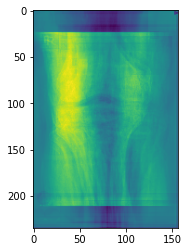

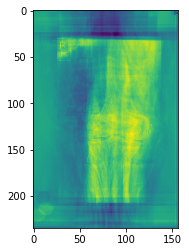

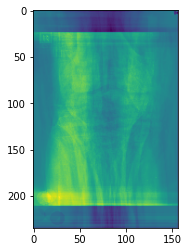

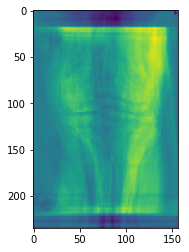

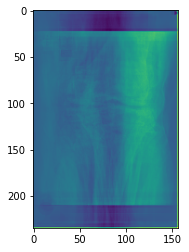

In [371]:
for i in range(5):
  op48.components_.shape
  plt.imshow((to48[i].reshape(1,-1)@op48.components_).reshape(235,156))
  plt.show()

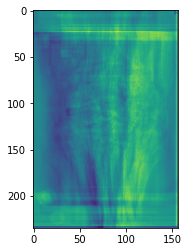

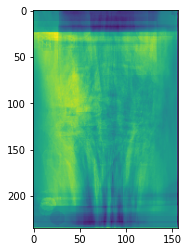

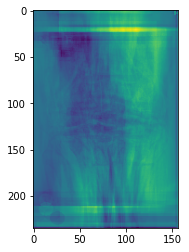

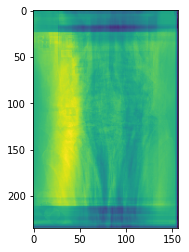

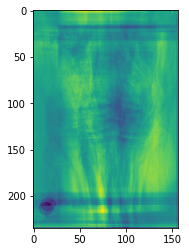

In [373]:
for i in range(5):
  np48.components_.shape
  plt.imshow((tn48[i].reshape(1,-1)@np48.components_).reshape(235,156))
  plt.show()

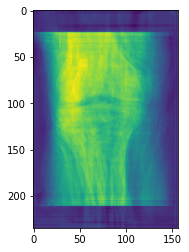

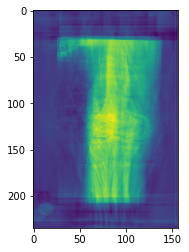

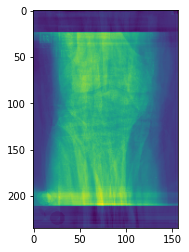

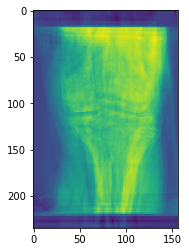

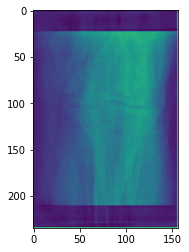

In [374]:
for i in range(5):
  op48.components_.shape
  plt.imshow(((to48[i].reshape(1,-1)@op48.components_)+osteoporotic_mean).reshape(235,156))
  plt.show()

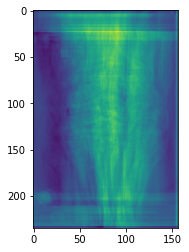

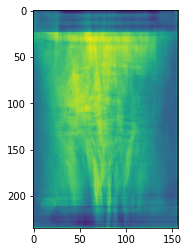

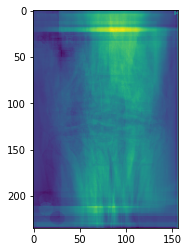

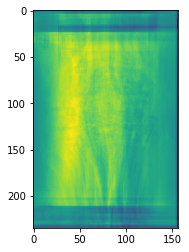

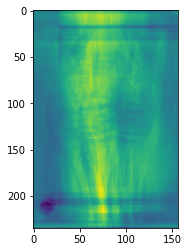

In [375]:
for i in range(5):
  #np48.components_.shape
  plt.imshow(((tn48[i].reshape(1,-1)@np48.components_)+normal_mean).reshape(235,156))
  plt.show()

In [387]:
path=%cd '/content/drive/MyDrive/CV_project/Saved_images'

/content/drive/MyDrive/CV_project/Saved_images


In [391]:
def pseudo(name,image,address):
    img_list = image.reshape(235,156)
    temp = 255*(img_list[0]-img_list[0].min())/(img_list[0].max()-img_list[0].min())
    image = cv2.cvtColor(img_list,cv2.COLOR_GRAY2BGR)
    img2 = image.copy().astype("float32")
    for i in range(img2.shape[2]):
        img2[:,:,i] = (img2[:,:,i]-np.min(img2[:,:,i]))/(np.max(img2[:,:,i])-np.min(img2[:,:,i]))
        img2[:,:,i] *= 255

    lut_list_bgr = np.zeros((256,1,3)).astype("uint8")

    for i in range(128,192):
        lut_list_bgr[i,0,2] = 4*(i-127.5)
        lut_list_bgr[i,0,1] = 255

    for j in range(192,256):
        lut_list_bgr[j,0,2] = 255
        lut_list_bgr[j,0,1] = 4*(191.25-j) + 255

    for k in range(0,64):
        lut_list_bgr[k,0,0] = 255
        lut_list_bgr[k,0,1] = 4*k

    for m in range(64,128):
        lut_list_bgr[m,0,0] = 4*(63.75-m)+255
        lut_list_bgr[m,0,1] = 255

    lut_list_bgrop = lut_list_bgr.astype("uint8")
    img2 = img2.astype("uint8")

    imp = cv2.LUT(img2,lut_list_bgrop)
    
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    centre_coord = np.argwhere(img_gray==np.amax(img_gray))
    centre = (np.mean(centre_coord,axis=0)).astype("uint8")
    count = 0
    if isinstance(centre,list):
        for i in centre_coord:
            imp = cv2.circle(imp,(i[1],i[0]),15,(255,255,255),2)
            count += 1
    else:
        count = 1
        imp = cv2.circle(imp,(centre[1],centre[0]),15,(255,255,255),2)
    
    cv2.imwrite(str(address)+str(name)+"_pseudo.png",imp)
    
    cv2_imshow(imp)
    cv2.waitKey(0)
    return count, imp

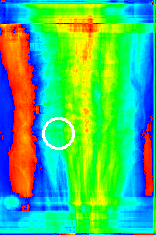

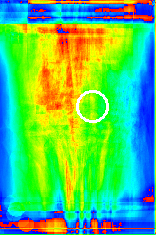

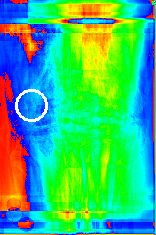

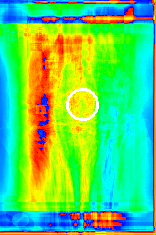

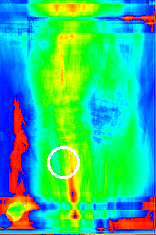

In [392]:
from google.colab.patches import cv2_imshow
for i in range(5):
  #np48.components_.shape
  pl=((tn48[i].reshape(1,-1)@np48.components_)+normal_mean).reshape(235,156)
  pl=np.asarray(pl,dtype='uint8')
  pseudo(i,pl,'Mean_added_normal')

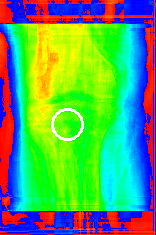

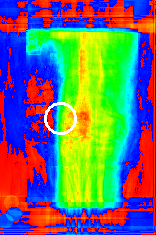

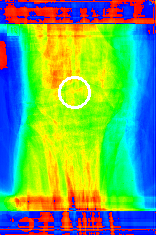

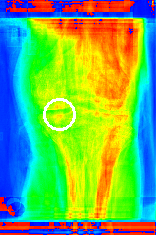

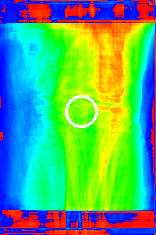

In [393]:
from google.colab.patches import cv2_imshow
for i in range(5):
  #np48.components_.shape
  pl=((to48[i].reshape(1,-1)@op48.components_)+osteoporotic_mean).reshape(235,156)
  pl=np.asarray(pl,dtype='uint8')
  pseudo(i,pl,'Mean_added_osteoporotic')

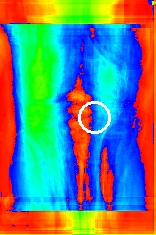

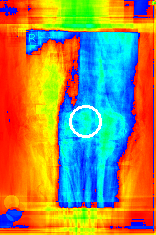

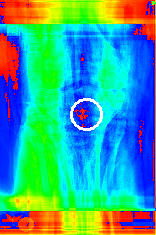

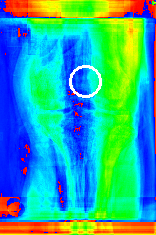

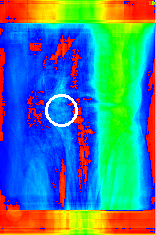

In [394]:
for i in range(5):
  #np48.components_.shape
  pl=(to48[i].reshape(1,-1)@op48.components_).reshape(235,156)
  pl=np.asarray(pl,dtype='uint8')
  pseudo(i,pl,'_osteoporotic')

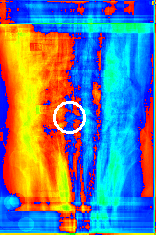

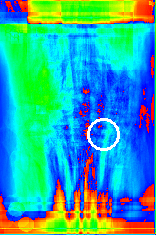

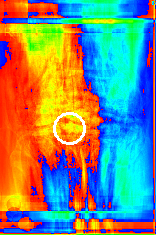

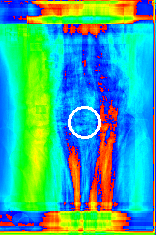

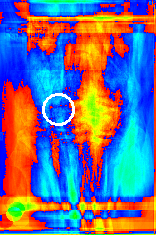

In [395]:
for i in range(5):
  #np48.components_.shape
  pl=(tn48[i].reshape(1,-1)@np48.components_).reshape(235,156)
  pl=np.asarray(pl,dtype='uint8')
  pseudo(i,pl,'_normal')

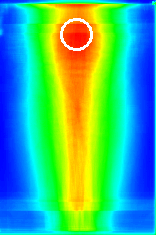

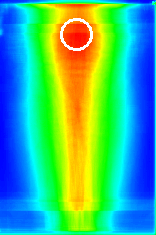

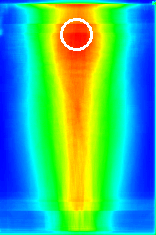

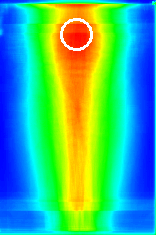

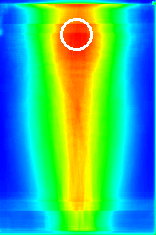

In [397]:
for i in range(5):
  n=npc[i].reshape(235,156)
  n1=n+normal_mean.reshape(235,156)
  n1=np.asarray(n1,'uint8')
  pseudo(i,n1,'Components_normal')

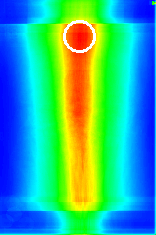

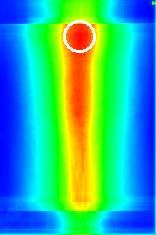

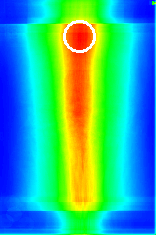

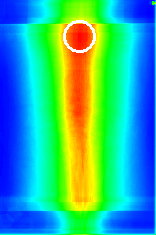

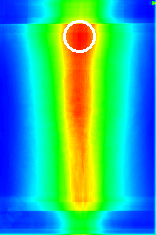

In [400]:
for i in range(5):
  o=opc[i].reshape(235,156)
  o=osteoporotic_mean.reshape(235,156)+o
  o1=np.asarray(o,'uint8')
  pseudo(i,o1,'Components_osteoporotic')